In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import percentileofscore
from scipy.optimize import minimize
import json


# install custom fonts
font_files = font_manager.findSystemFonts(fontpaths="/Users/scc/miniconda3/envs/ml-base/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# image parameters
%config InlineBackend.figure_format = 'svg'

mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['font.family'] = 'Lato'  
mpl.rcParams['font.size'] = 14

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['axes.linewidth']=0.7

## Import Weather Data

In [215]:
# importing & reformat weather data
# sam http://www.nerc-bas.ac.uk/icd/gjma/sam.html
# enso noaa
# iod https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/dmi.had.long.data
enso = pd.read_csv("weather_files/enso.csv")
enso.set_index('Year', inplace=True)

sam = pd.read_csv('weather_files/sam.txt', sep='\s+')

iod = pd.read_csv('weather_files/dmi.txt', sep='\s+')

enso_stack = enso.stack().reset_index()
enso_stack.columns = ['Year', 'Period', 'ENSO']

sam_stack = sam.stack().reset_index()
sam_stack.columns = ['Year', 'Period', 'SAM']

iod_stack = iod.stack().reset_index()
iod_stack.columns = ['Year', 'Period', 'IOD']

### Smooth Data

In [216]:
def smooth_data(df):
    # Create a datetime index
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Period'], format='%Y%b')
    df = df.set_index('Date')
    # Sort the index
    df = df.sort_index()
    
    # Calculate the 3-month rolling average
    smoothed = df.iloc[:, -1].rolling(window=3, center=True).mean()
    
    # Create a new dataframe with the smoothed data
    smoothed_df = pd.DataFrame({
        'Year': smoothed.index.year,
        'Period': smoothed.index.strftime('%b'),
        f'{df.columns[-1]}': smoothed.values
    })
    
    # Shift the Period names forward by one month
    month_shift = {
        'Jan': 'DJF', 'Feb': 'JFM', 'Mar': 'FMA', 'Apr': 'MAM', 'May': 'AMJ', 'Jun': 'MJJ',
        'Jul': 'JJA', 'Aug': 'JAS', 'Sep': 'ASO', 'Oct': 'SON', 'Nov': 'OND', 'Dec': 'NDJ'
    }
    smoothed_df['Period'] = smoothed_df['Period'].map(month_shift)
    
    return smoothed_df.dropna()

sam_smoothed = smooth_data(sam_stack)
iod_smoothed = smooth_data(iod_stack)
period_mapping = {
    'DJF': 'JAN',
    'JFM': 'FEB',
    'FMA': 'MAR',
    'MAM': 'APR',
    'AMJ': 'MAY',
    'MJJ': 'JUN',
    'JJA': 'JUL',
    'JAS': 'AUG',
    'ASO': 'SEP',
    'SON': 'OCT',
    'OND': 'NOV',
    'NDJ': 'DEC'
}

# Rename the periods in the merged_oni DataFrame
enso_stack['Period'] = enso_stack['Period'].replace(period_mapping)
iod_smoothed['Period'] = iod_smoothed['Period'].replace(period_mapping)
sam_smoothed['Period'] = sam_smoothed['Period'].replace(period_mapping)
merged_df = pd.merge(enso_stack, sam_smoothed, on=['Year', 'Period'], how='outer')
merged_df = pd.merge(merged_df, iod_smoothed, on=['Year', 'Period'], how='outer')

# Create a datetime column
merged_df['Date'] = pd.to_datetime(merged_df['Year'].astype(str) + '-' + merged_df['Period'], format='%Y-%b')

# Sort the DataFrame by date
merged_df_weather = merged_df.sort_values('Date')

In [217]:
merged_df_weather

,Year,Period,ENSO,SAM,IOD,Date
3,2006,FEB,NaN,0.123333,-0.222000,2006-02-01
6,2006,MAR,NaN,-0.293333,-0.182000,2006-03-01
0,2006,APR,NaN,1.083333,-0.149333,2006-04-01
7,2006,MAY,NaN,1.213333,-0.093667,2006-05-01
5,2006,JUN,NaN,1.980000,-0.075333,2006-06-01
...,...,...,...,...,...,...
215,2024,APR,NaN,1.410000,NaN,2024-04-01
222,2024,MAY,NaN,1.550000,NaN,2024-05-01
220,2024,JUN,NaN,1.243333,NaN,2024-06-01
219,2024,JUL,NaN,-0.803333,NaN,2024-07-01


### Filter & Plot Data

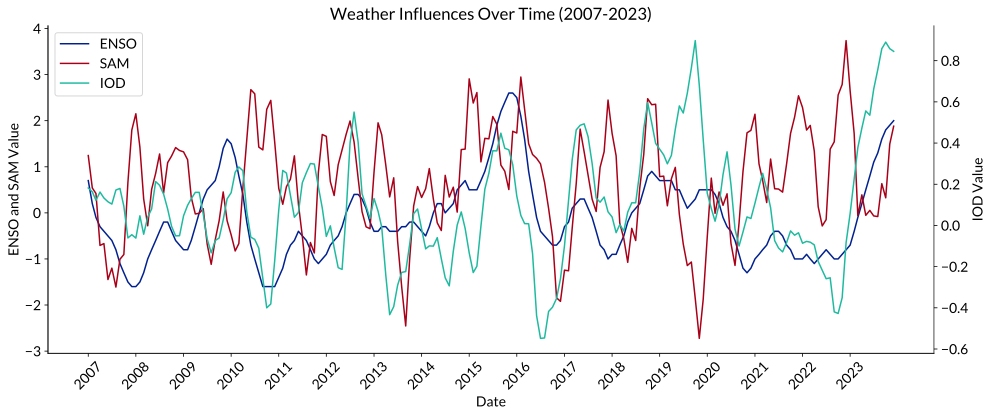

In [218]:
# Filter the data from January 2007 to December 2023
filtered_df = merged_df_weather[(merged_df_weather['Date'] >= '2007-01-01') & (merged_df_weather['Date'] <= '2023-12-31')]

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Plot ENSO and SAM on the left y-axis
ax1.plot(filtered_df['Date'], filtered_df['ENSO'], label='ENSO', color='#00208F')
ax1.plot(filtered_df['Date'], filtered_df['SAM'], label='SAM', color='#A90018')

# Plot IOD on the right y-axis
ax2.plot(filtered_df['Date'], filtered_df['IOD'], label='IOD', color='#1EBA9F')

# Customize the plot
ax1.set_title('Weather Influences Over Time (2007-2023)')
ax1.set_xlabel('Date')
ax1.set_ylabel('ENSO and SAM Value')
ax2.set_ylabel('IOD Value')

# Set x-axis ticks to show every year
years = pd.date_range(start='2007-01-01', end='2023-12-31', freq='YS')
ax1.set_xticks(years)
ax1.set_xticklabels(years.year, rotation=45)

# Add right spine for ax2
ax2.spines['right'].set_visible(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

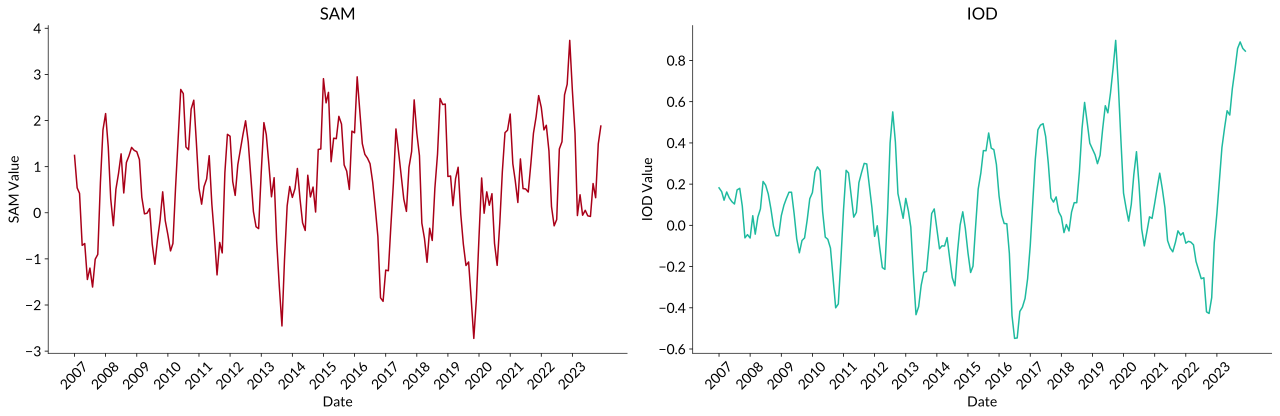

In [219]:
# Filter the data from January 2007 to December 2023
filtered_df = merged_df_weather[(merged_df_weather['Date'] >= '2007-01-01') & (merged_df_weather['Date'] <= '2023-12-31')]

# Create figure with three subplots
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(18, 6))


# Plot SAM
ax2.plot(filtered_df['Date'], filtered_df['SAM'], color='#A90018')
ax2.set_title('SAM')
ax2.set_xlabel('Date')
ax2.set_ylabel('SAM Value')

# Plot IOD
ax3.plot(filtered_df['Date'], filtered_df['IOD'], color='#1EBA9F')
ax3.set_title('IOD')
ax3.set_xlabel('Date')
ax3.set_ylabel('IOD Value')

# Set x-axis ticks for all subplots
years = pd.date_range(start='2007-01-01', end='2023-12-31', freq='YS')
for ax in [ax1, ax2, ax3]:
    ax.set_xticks(years)
    ax.set_xticklabels(years.year, rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()
plt.savefig('/Users/scc/website/static/images/weather_blogpost/climate_influences_SAM_IOD_overtime.jpg', dpi=300)

# Show the plot
plt.show()

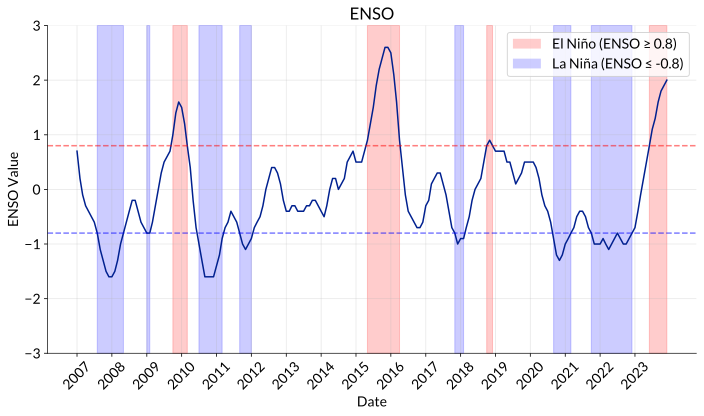

In [220]:
# Filter the data from January 2007 to December 2023
filtered_df = merged_df_weather[(merged_df_weather['Date'] >= '2007-01-01') & (merged_df_weather['Date'] <= '2023-12-31')]

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create patches for the legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.2, label='El Niño (ENSO ≥ 0.8)'),
    Patch(facecolor='blue', alpha=0.2, label='La Niña (ENSO ≤ -0.8)')
]

# Plot ENSO with shaded background
ax.fill_between(filtered_df['Date'], -3, 3, 
                where=filtered_df['ENSO'] >= 0.8,
                color='red', alpha=0.2)
ax.fill_between(filtered_df['Date'], -3, 3, 
                where=filtered_df['ENSO'] <= -0.8,
                color='blue', alpha=0.2)
ax.plot(filtered_df['Date'], filtered_df['ENSO'], color='#00208F')
ax.set_title('ENSO')
ax.set_xlabel('Date')
ax.set_ylabel('ENSO Value')
ax.set_ylim(-3, 3)

# Add legend
ax.legend(handles=legend_elements, loc='upper right')

# Set x-axis ticks
years = pd.date_range(start='2007-01-01', end='2023-12-31', freq='YS')
ax.set_xticks(years)
ax.set_xticklabels(years.year, rotation=45)
ax.grid(True, alpha=0.3)

# Add horizontal lines at ±0.8
ax.axhline(y=0.8, color='red', linestyle='--', alpha=0.5)
ax.axhline(y=-0.8, color='blue', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.savefig('/Users/scc/website/static/images/weather_blogpost/enso_overtime.jpg', dpi=300)

# Show the plot
plt.show()

## Import Flight Data

In [221]:
df = pd.read_csv("241016_all_flights_clean.csv", index_col=0)
# convert column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
df['year'] = df['date'].dt.year
df

,Points,date,name,km,km/h,Airfield,Club,Region of club,Aircraft,year
0,1330.130000,2015-01-02,David Jansen,1582.26,144.44,Kingaroy,Kingaroy Soaring Club,AU-QLD,ASG 29E 18m,2015
1,1237.610000,2020-11-27,Pete Temple,1312.69,135.92,Gawler,Adelaide Soaring Club,AU-SA,ASG 29 18m,2020
2,1102.170000,2014-01-17,Chris Woolley,1299.52,120.45,Kingaroy,Kingaroy Soaring Club,AU-QLD,Ventus 2cM/18m,2014
3,1040.930000,2009-12-23,Lubor Kuvik,1252.96,127.27,Corowa Rwx,Air Sympatia,TS-SK,ASG 29 18m,2009
4,1381.370000,2013-12-19,Matthew Scutter,1250.66,141.51,Gawler,Adelaide Soaring Club,AU-SA,Discus 2a,2013
...,...,...,...,...,...,...,...,...,...,...
76519,1.039252,2018-02-07,Lyle McLean,0.80,66.98,West Wyalong,Bathurst Soaring Club,AU-NSW,Mini Nimbus,2018
76520,1.071154,2020-11-28,John Spronk,0.80,82.29,Barmera,Waikerie Gliding Club,AU,LS 4,2020
76521,1.020000,2020-11-28,John Spronk,0.76,76.00,Barmera,Waikerie Gliding Club,AU,LS 4,2020
76522,0.764486,2023-02-13,tim hood,0.59,57.41,Archerfield,Kingaroy Soaring Club,AU,LS 3,2023


#### Assign each airfield to a state - this was done with the help of Claude3.5. I gave it the list of airfields and asked it to assign each to the right state.

In [222]:
# allocate state to each airfield
airfield_state_dict = {
    'Adelaide Paraf (AU / SA/N)': 'SA',
    'Adels Grove': 'QLD',
    'Adels Grove (AU / QLD)': 'QLD',
    'Adora Downs (AU / QLD)': 'QLD',
    'Albany (AU / WA)': 'WA',
    'Albury (AU / VIC)': 'VIC',
    'Alice Springs': 'NT',
    'Ararat': 'VIC',
    'Archerfield': 'QLD',
    'Ardlethan': 'NSW',
    'Arkapena airstrip (AU / SA/N)': 'SA',
    'Arrowfield Coolm (AU / NSW)': 'NSW',
    'Atherton (AU / QLD)': 'QLD',
    'Augathella (AU / QLD)': 'QLD',
    'Bacchus Mars': 'VIC',
    'Bacchus Marsh': 'VIC',
    'Bairnsdale (AU / VIC)': 'VIC',
    'Balaklava': 'SA',
    'Ballarat': 'VIC',
    'Ballidu': 'WA',
    'Ballidu (AU / WA)': 'WA',
    'Balranald': 'NSW',
    'Balranald (AU / NSW)': 'NSW',
    'Barmera': 'SA',
    'Barraba': 'NSW',
    'Bathurst': 'NSW',
    'Benalla': 'VIC',
    'Benambra (AU / VIC)': 'VIC',
    'Benambra Townshi (AU / VIC)': 'VIC',
    'Berrigan Ad (AU / VIC)': 'VIC',
    'Beulah 1': 'VIC',
    'Beverley': 'WA',
    'Beverley Hills (AU / QLD)': 'QLD',
    'Bindoon (AU / WA)': 'WA',
    'Birchip': 'VIC',
    'Blackall': 'QLD',
    'Blackall (AU / QLD)': 'QLD',
    'Blinman (AU / SA/N)': 'SA',
    'Boggabri': 'NSW',
    'Boginderra (AU / NSW)': 'NSW',
    'Bogong Park (AU / VIC)': 'VIC',
    'Bond Springs': 'NT',
    'Boonah': 'QLD',
    'Boort': 'VIC',
    'Bordertown': 'SA',
    'Boundain': 'NSW',
    'Bourke': 'NSW',
    'Brewarrina (AU / NSW)': 'NSW',
    'Broken Hill (AU / NSW)': 'NSW',
    'Bruce Rock': 'WA',
    'Bunyan': 'NSW',
    'Bunyan Airfield': 'NSW',
    'Burketown': 'QLD',
    'Burketown (AU / QLD)': 'QLD',
    'Caboolture': 'QLD',
    'Caloundra (AU / QLD)': 'QLD',
    'Camden': 'NSW',
    'Camden 06rwy': 'NSW',
    'Camden 10rwy': 'NSW',
    'Camden Nsw': 'NSW',
    'Canberra Act (AU / VIC)': 'VIC',
    'Carrik': 'NSW',
    'Charleville': 'QLD',
    'Charters Towers': 'QLD',
    'Charters Towers (AU / QLD)': 'QLD',
    'Chillagoe': 'QLD',
    'Chillagoe (AU / QLD)': 'QLD',
    'Chinchilla': 'QLD',
    'Chinchilla G': 'QLD',
    'Clifton': 'QLD',
    'Clifton Ad (AU / QLD)': 'QLD',
    'Cloncurry (AU / QLD)': 'QLD',
    'Cobar (AU / NSW)': 'NSW',
    'Condobolin': 'NSW',
    'Coober Pedy (AU / SA/N)': 'SA',
    'Coonamble (AU / NSW)': 'NSW',
    'Coongulla': 'VIC',
    'Cootamundra': 'NSW',
    'Corowa': 'NSW',
    'Corowa Rwx': 'NSW',
    'Corryong (AU / VIC)': 'VIC',
    'Cowra': 'NSW',
    'Croydon': 'QLD',
    'Croydon (AU / QLD)': 'QLD',
    'Cunderdin': 'WA',
    'Dalby': 'QLD',
    'Deniliquin': 'NSW',
    'Deniliquin (AU / VIC)': 'VIC',
    'Dimbulah': 'QLD',
    'Dirranbandi (AU / QLD)': 'QLD',
    'Dixilea Fiel': 'NSW',
    'Donald Vic (AU / VIC)': 'VIC',
    'Dowerin': 'WA',
    'Dowerin (AU / WA)': 'WA',
    'Dubbo (AU / NSW)': 'NSW',
    'Dululu': 'QLD',
    'Dunmore Manila': 'NSW',
    'Einasleigh': 'QLD',
    'Elengerah': 'NSW',
    'Elliott Field': 'NT',
    'Elliott Rive': 'NT',
    'Farrell Flat': 'SA',
    'Finley': 'NSW',
    'Fiskville (AU / VIC)': 'VIC',
    'Forbes Asd': 'NSW',
    'Gaineys Farm (AU / NSW)': 'NSW',
    'Gawler': 'SA',
    'George Lees Af (AU / QLD)': 'QLD',
    'Georgetown Qld (AU / QLD)': 'QLD',
    'Gilgandra (AU / NSW)': 'NSW',
    'Glenbrook': 'NSW',
    'Glencoe': 'NSW',
    'Glenmaggie1 (AU / VIC)': 'VIC',
    'Gloucester': 'NSW',
    'Gloucester (AU / NSW)': 'NSW',
    'Goondiwindi': 'QLD',
    'Goondiwindi (AU / QLD)': 'QLD',
    'Grampians': 'VIC',
    'Greenthorpe': 'NSW',
    'Griffith (AU / NSW)': 'NSW',
    'Gulgong Af': 'NSW',
    'Gundaroo': 'NSW',
    'Gunnedah': 'NSW',
    'Gunnedah Af (AU / NSW)': 'NSW',
    'Gympie': 'QLD',
    'Gympie Kybon': 'QLD',
    'Gympie Kybong (AU / QLD)': 'QLD',
    'Happy Valley Ul (AU / NSW)': 'NSW',
    'Hay': 'NSW',
    'Hay Nsw (AU / NSW)': 'NSW',
    'Hervey Bay (AU / QLD)': 'QLD',
    'Hillston (AU / NSW)': 'NSW',
    'Hopetoun': 'WA',
    'Horsham': 'VIC',
    'Hyden (AU / WA)': 'WA',
    'Innisfail (AU / QLD)': 'QLD',
    'Irvindale Heli A (AU / QLD)': 'QLD',
    'Jamestown (AU / SA/N)': 'SA',
    'Jemalong': 'NSW',
    'Jerilderie': 'NSW',
    'Jerilderie (AU / VIC)': 'VIC',
    'Kalgoorlie (AU / WA)': 'WA',
    'Karumba (AU / QLD)': 'QLD',
    'Katoomba': 'NSW',
    'Kawhatau (NZ / N)': 'NZ',
    'Kellerberrin': 'WA',
    'Kelvin Station': 'QLD',
    'Kentucky': 'NSW',
    'Kerang (AU / VIC)': 'VIC',
    'Khancoban': 'NSW',
    'Khancoban (AU / VIC)': 'VIC',
    'Kingaroy': 'QLD',
    'Kooralbyn': 'QLD',
    'Kumbria Strip (AU / QLD)': 'QLD',
    'Kwinana Station (AU / NSW)': 'NSW',
    'Lake Keepit': 'NSW',
    'Leeton': 'NSW',
    'Leeton A D': 'NSW',
    'Leongatha': 'VIC',
    'Leongatha1': 'VIC',
    'Liddel (AU / NSW)': 'NSW',
    'Lockhart': 'NSW',
    'Longreach (AU / QLD)': 'QLD',
    'Lyndley': 'NSW',
    'Mangrove Mountain': 'NSW',
    'Mangrove Mt': 'NSW',
    'Manilla1 A F': 'NSW',
    'Mareeba': 'QLD',
    'Mareeba (AU / QLD)': 'QLD',
    'Marree (AU / SA/N)': 'SA',
    'McCaffery': 'NSW',
    'McCaffery Field': 'NSW',
    'Merredin': 'WA',
    'Milawa': 'VIC',
    'Mildura': 'VIC',
    'Millicent': 'SA',
    'Millmerran': 'QLD',
    'Mitchell (AU / QLD)': 'QLD',
    'Mitta Mitta (AU / VIC)': 'VIC',
    'Morawa': 'WA',
    'Moree (AU / NSW)': 'NSW',
    'Mount Beauty': 'VIC',
    'Mount Isa': 'QLD',
    'Mudgee': 'NSW',
    'Mudgee (AU / NSW)': 'NSW',
    'Mungeribar (AU / NSW)': 'NSW',
    'Mungindi (AU / QLD)': 'QLD',
    'Murgon': 'QLD',
    'Murray Bridge Sa (AU / SA/N)': 'SA',
    'Narrabri Nsw (AU / NSW)': 'NSW',
    'Narrogin': 'WA',
    'Narromine': 'NSW',
    'Ningham Station (AU / WA)': 'WA',
    'Northam (AU / WA)': 'WA',
    'Nyngan (AU / NSW)': 'NSW',
    'Orange': 'NSW',
    'Parkes': 'NSW',
    'Parkes (AU / NSW)': 'NSW',
    'Peak Hill': 'NSW',
    'Pinnarendi': 'NSW',
    'Pipers Field': 'NSW',
    'Pittsworth': 'QLD',
    'Point Cook (AU / VIC)': 'VIC',
    'Polo Flat': 'NSW',
    'Pomonal': 'VIC',
    'Porepunkah': 'VIC',
    'Porepunkah Af (AU / VIC)': 'VIC',
    'Porepunkhah (AU / VIC)': 'VIC',
    'Puckapunyal': 'VIC',
    'Quairading': 'WA',
    'Quairading (AU / WA)': 'WA',
    'Rawnsley Park': 'SA',
    'Raywood': 'VIC',
    'Raywood (AU / VIC)': 'VIC',
    'Renmark': 'SA',
    'Richmond Nsw': 'NSW',
    'Roma Qld': 'QLD',
    'Rowsley/Brooks Landing': 'VIC',
    'Scone': 'NSW',
    'Southern Cross': 'WA',
    'Southern Cross (AU / WA)': 'WA',
    'Southport': 'QLD',
    'St George Qld (AU / QLD)': 'QLD',
    'Stawell': 'VIC',
    'Stawell (AU / VIC)': 'VIC',
    'Stirling Range Retreat': 'WA',
    'Stonefield': 'NSW',
    'Strilings Airstr (AU / WA)': 'WA',
    'Sunraysia': 'VIC',
    'Sunraysia (AU / VIC)': 'VIC',
    'Tambo': 'QLD',
    'Temora': 'NSW',
    'Thargomindah': 'QLD',
    'The Oaks': 'NSW',
    'The Vale (AU / TAS)': 'TAS',
    'Tibooburra (AU / NSW)': 'NSW',
    'Tocumwal': 'NSW',
    'Tocumwal (AU / NSW)': 'NSW',
    'Togo Station': 'NSW',
    'Tooraweenah': 'NSW',
    'Toowoomba (AU / QLD)': 'QLD',
    'Tottenham': 'NSW',
    'Towrang': 'NSW',
    'Trangie': 'NSW',
    'Trangie Exact (AU / NSW)': 'NSW',
    'Tumut': 'NSW',
    'Upper Horton Wyl': 'NSW',
    'Waikerie': 'SA',
    'Walcha': 'NSW',
    'Walgett (AU / NSW)': 'NSW',
    'Wallabadah': 'NSW',
    'Wanaaring Ns (AU / NSW)': 'NSW',
    'Wangaratta': 'VIC',
    'Wangaratta (AU / VIC)': 'VIC',
    'Warkworth': 'NSW',
    'Warracknabeal': 'VIC',
    'Warren': 'NSW',
    'Warwick': 'QLD',
    'Wave Rock': 'WA',
    'Wedderburn': 'NSW',
    'Wedderburn (AU / NSW)': 'NSW',
    'Wellington Nsw (AU / NSW)': 'NSW',
    'Wentworth (AU / NSW)': 'NSW',
    'West Wyalong': 'NSW',
    'West Wyalong Nsw (AU / NSW)': 'NSW',
    'White Cliffs Nsw (AU / NSW)': 'NSW',
    'White Gum': 'NSW',
    'Wilcannia (AU / NSW)': 'NSW',
    'Wilton (AU / QLD)': 'QLD',
    'Winton (AU / QLD)': 'QLD',
    'Wondai': 'QLD',
    'Wondai (AU / QLD)': 'QLD',
    'Wondoola': 'NSW',
    'Wongan Hills': 'WA',
    'Woodbury (AU / VIC)': 'VIC',
    'Wyalkatchem (AU / WA)': 'WA',
    'Yarrawonga': 'VIC',
    'Yarrawonga S (AU / VIC)': 'VIC',
    'York': 'WA',
    'York (AU / WA)': 'WA',
}


In [223]:
# add new column with State parameter
df['State'] = df['Airfield'].map(airfield_state_dict)

In [224]:
df_flights = df

#### Calculate average of top 250 flights in any 3 months period

In [225]:
def calculate_top_flights(num_flights, state, df_input):
    df = df_input[df_input['State'] == state]

    # Extract the year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Define the 3-month periods
    periods = {
        'DJF': [12, 1, 2],
        'JFM': [1, 2, 3],
        'FMA': [2, 3, 4],
        'MAM': [3, 4, 5],
        'AMJ': [4, 5, 6],
        'MJJ': [5, 6, 7],
        'JJA': [6, 7, 8],
        'JAS': [7, 8, 9],
        'ASO': [8, 9, 10],
        'SON': [9, 10, 11],
        'OND': [10, 11, 12],
        'NDJ': [11, 12, 1]
    }

    # Create a DataFrame to hold the mean points for each 3-month period
    mean_points = {period: [] for period in periods}

    # Calculate mean points for each year and each 3-month period
    for year in range(2007, 2024):  # From 2007 to 2023
        for period, months in periods.items():
            # Adjust the year for periods that span into the next year
            if period == 'DJF':
                # DJF of the current year includes Dec of the previous year
                period_data = df[(df['year'] == year - 1) & (df['month'].isin([12]))]
                period_data = pd.concat([period_data, df[(df['year'] == year) & (df['month'].isin([1, 2]))]])
            elif period == 'NDJ':
                # NDJ of the current year includes Nov, Dec of the current year and Jan of the next year
                period_data = df[(df['year'] == year) & (df['month'].isin([11, 12]))]
                period_data = pd.concat([period_data, df[(df['year'] == year + 1) & (df['month'] == 1)]])
            else:
                # For other periods, just use the current year
                period_data = df[(df['year'] == year) & (df['month'].isin(months))]

            # Get the top 250 flights based on points for this period
            top_flights = period_data.nlargest(num_flights, 'Points')

            # Calculate the mean points for the top 250 flights
            mean_point = top_flights['Points'].mean() if not top_flights.empty else None
            mean_points[period].append(mean_point)

    # Create a DataFrame from the mean points dictionary
    mean_points_df = pd.DataFrame(mean_points, index=range(2007, 2024))

    # Display the resulting DataFrame
    mean_points_df.index.name = 'Year'
    mean_points_df.replace(0, np.nan, inplace=True)

    return mean_points_df

In [226]:
def stack_merge_df(df):
    mean_points_df_stack = df.stack().reset_index()
    mean_points_df_stack.columns = ['Year', 'Period', 'MeanPoints'] 
    # print(mean_points_df_stack

    # Create a mapping dictionary for the periods
    period_mapping = {
        'DJF': 'JAN',
        'JFM': 'FEB',
        'FMA': 'MAR',
        'MAM': 'APR',
        'AMJ': 'MAY',
        'MJJ': 'JUN',
        'JJA': 'JUL',
        'JAS': 'AUG',
        'ASO': 'SEP',
        'SON': 'OCT',
        'OND': 'NOV',
        'NDJ': 'DEC'
    }

    # Rename the periods in the merged_oni DataFrame
    mean_points_df_stack['Period'] = mean_points_df_stack['Period'].replace(period_mapping)

    merged_weather_flights = pd.merge(mean_points_df_stack, merged_df_weather, on=['Year', 'Period'], how='inner')
    return merged_weather_flights

In [227]:
states = ["QLD", "WA", "NSW", "VIC", "NT", "SA"]

In [228]:
# Initialize a dictionary to store the DataFrames for each state
df_new = {}

for state in states:
    df = calculate_top_flights(250, state, df_flights)  # Calculate top flights for the current state
    # print(df)
    df_new[f"{state}"] = stack_merge_df(df)  # Store the DataFrame in the dictionary
    # print(df_new[f"{state}"])


qld = df_new["QLD"]
nsw = df_new["NSW"]
sa = df_new["SA"]
vic = df_new["VIC"]
nt = df_new["NT"]
wa = df_new["WA"]

qld

/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_91770/382048821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_91770/382048821.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.month
/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_91770/382048821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,Year,Period,MeanPoints,ENSO,SAM,IOD,Date
0,2007,JAN,389.804444,0.7,1.243333,0.182000,2007-01-01
1,2007,FEB,348.900000,0.2,0.540000,0.163333,2007-02-01
2,2007,MAR,302.395741,-0.1,0.420000,0.122000,2007-03-01
3,2007,APR,300.829333,-0.3,-0.706667,0.162000,2007-04-01
4,2007,MAY,287.259455,-0.4,-0.666667,0.133333,2007-05-01
...,...,...,...,...,...,...,...
199,2023,AUG,292.197192,1.3,-0.080000,0.756333,2023-08-01
200,2023,SEP,442.384030,1.6,0.633333,0.858333,2023-09-01
201,2023,OCT,439.602190,1.8,0.326667,0.890000,2023-10-01
202,2023,NOV,421.985345,1.9,1.493333,0.858333,2023-11-01


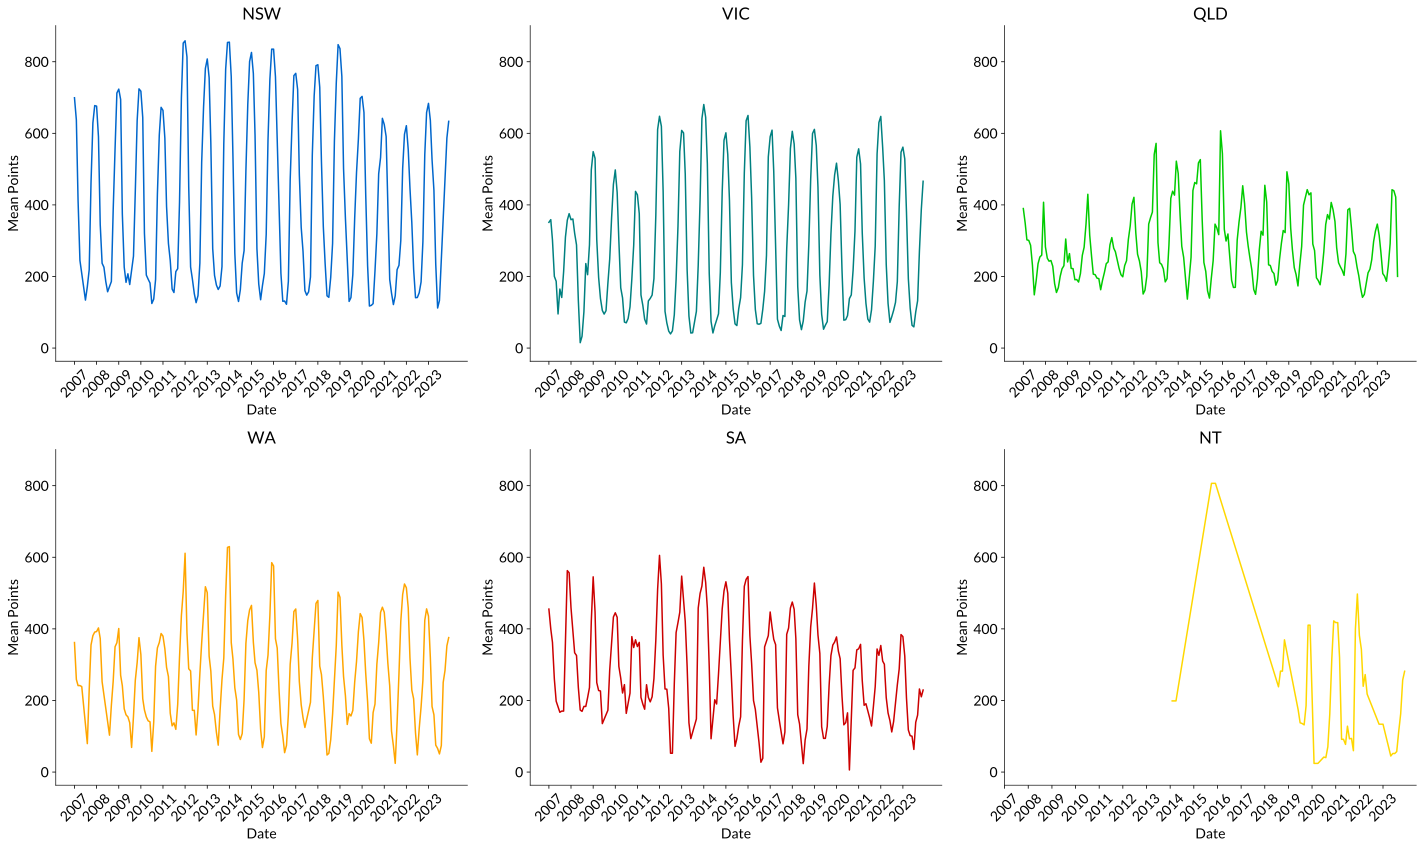

In [229]:
# Create figure with six subplots (2x3 grid)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12))

# Dictionary mapping states to axes and colors
state_config = {
    'NSW': {'ax': ax1, 'color': '#0066CC'},  # blue
    'VIC': {'ax': ax2, 'color': '#008080'},  # teal
    'QLD': {'ax': ax3, 'color': '#00CC00'},  # green
    'WA': {'ax': ax4, 'color': '#FFA500'},   # orange
    'SA': {'ax': ax5, 'color': '#CC0000'},   # red
    'NT': {'ax': ax6, 'color': '#FFD700'}    # yellow
}

# Dictionary mapping states to DataFrames
state_dfs = {
    'NSW': nsw,
    'VIC': vic,
    'QLD': qld,
    'WA': wa,
    'SA': sa,
    'NT': nt
}

# Find global min and max values across all states
global_min = float('inf')
global_max = float('-inf')
for df in state_dfs.values():
    current_min = df['MeanPoints'].min()
    current_max = df['MeanPoints'].max()
    global_min = min(global_min, current_min)
    global_max = max(global_max, current_max)

# Add some padding to the limits (5% on each end)
y_padding = (global_max - global_min) * 0.05
y_min = global_min - y_padding
y_max = global_max + y_padding

# Plot each state
for state, config in state_config.items():
    df = state_dfs[state]
    ax = config['ax']
    color = config['color']
    
    # Plot MeanPoints
    ax.plot(df['Date'], df['MeanPoints'], color=color)
    ax.set_title(state)
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Points')
    
    # Set x-axis ticks
    years = pd.date_range(start='2007-01-01', end='2023-12-31', freq='YS')
    ax.set_xticks(years)
    ax.set_xticklabels(years.year, rotation=45)
    
    # Set y-axis limits
    ax.set_ylim(y_min, y_max)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the plot
plt.savefig('/Users/scc/website/static/images/weather_blogpost/mean_points_by_state.jpg', dpi=300)

# Show the plot
plt.show()

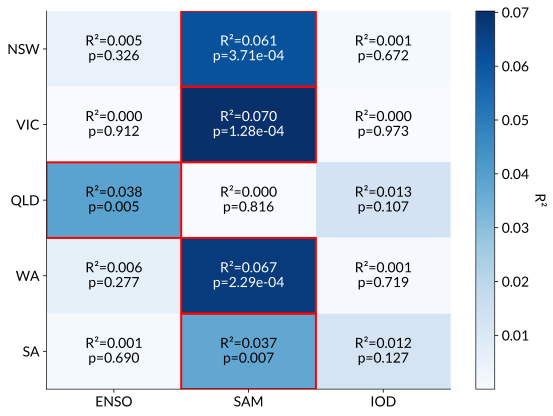

In [230]:
# Create lists to store results
states = ['NSW', 'VIC', 'QLD', 'WA', 'SA']
parameters = ['ENSO', 'SAM', 'IOD']
r_squared = np.zeros((len(states), len(parameters)))
p_values = np.zeros((len(states), len(parameters)))

# Calculate correlations and p-values for each state and parameter
for i, state in enumerate(states):
    df = state_dfs[state].dropna()  # Get data for current state
    
    for j, param in enumerate(parameters):
        # Calculate correlation and p-value
        slope, intercept, r_value, p_value, std_err = stats.linregress(df[param], df['MeanPoints'])
        r_squared[i,j] = r_value**2
        p_values[i,j] = p_value

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap with blue color scheme
im = ax.imshow(r_squared, cmap='Blues', aspect='auto')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('R²', rotation=-90, va="bottom")

# Show all ticks and label them
ax.set_xticks(np.arange(len(parameters)))
ax.set_yticks(np.arange(len(states)))
ax.set_xticklabels(parameters)
ax.set_yticklabels(states)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Add text annotations with R² and p-values
for i in range(len(states)):
    for j in range(len(parameters)):
        # Format p-value based on its magnitude
        if p_values[i,j] < 0.001:
            p_text = f'{p_values[i,j]:.2e}'
        else:
            p_text = f'{p_values[i,j]:.3f}'
            
        text = f'R²={r_squared[i,j]:.3f}\np={p_text}'
        
        # Determine text color based on R² value
        text_color = 'white' if r_squared[i,j] > 0.05 else 'black'
        
        # Add text
        ax.text(j, i, text, ha="center", va="center", color=text_color)
        
        # Add red frame for significant correlations
        if p_values[i,j] < 0.05:
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

# Add title
# ax.set_title('Correlation between Weather Parameters and Mean Points by State')

# Adjust layout
plt.tight_layout()

# Save plot
plt.savefig('/Users/scc/website/static/images/weather_blogpost/correlation_heatmap.jpg', dpi=300)

# Show plot
plt.show()

In [231]:
# First rename the MeanPoints columns in each dataframe
qld = qld.rename(columns={'MeanPoints': 'QLD'})
nsw = nsw.rename(columns={'MeanPoints': 'NSW'})
vic = vic.rename(columns={'MeanPoints': 'VIC'})
wa = wa.rename(columns={'MeanPoints': 'WA'})
sa = sa.rename(columns={'MeanPoints': 'SA'})

# Merge all dataframes
df = qld.merge(nsw, on=['Year', 'Period', 'ENSO', 'SAM', 'IOD', 'Date'], how='outer')\
              .merge(vic, on=['Year', 'Period', 'ENSO', 'SAM', 'IOD', 'Date'], how='outer')\
              .merge(wa, on=['Year', 'Period', 'ENSO', 'SAM', 'IOD', 'Date'], how='outer')\
              .merge(sa, on=['Year', 'Period', 'ENSO', 'SAM', 'IOD', 'Date'], how='outer')

In [232]:
df

,Year,Period,QLD,ENSO,SAM,IOD,Date,NSW,VIC,WA,SA
0,2007,APR,300.829333,-0.3,-0.706667,0.162000,2007-04-01,244.781047,200.282353,241.513846,259.861111
1,2007,AUG,188.083333,-0.8,-1.610000,0.172000,2007-08-01,171.559485,141.400453,79.410000,170.246667
2,2007,DEC,407.300000,-1.6,1.796667,-0.045000,2007-12-01,677.398360,375.484206,391.025833,556.681250
3,2007,FEB,348.900000,0.2,0.540000,0.163333,2007-02-01,637.131480,358.770729,258.654231,399.773200
4,2007,JAN,389.804444,0.7,1.243333,0.182000,2007-01-01,699.352360,351.220317,361.768727,455.218333
...,...,...,...,...,...,...,...,...,...,...,...
199,2023,MAR,267.981252,-0.1,-0.060000,0.377333,2023-03-01,526.536293,380.541443,182.962924,207.341985
200,2023,MAY,200.883896,0.5,-0.053333,0.556000,2023-05-01,234.357595,111.812809,75.195820,101.631169
201,2023,NOV,421.985345,1.9,1.493333,0.858333,2023-11-01,586.700092,387.074941,352.594272,210.233616
202,2023,OCT,439.602190,1.8,0.326667,0.890000,2023-10-01,465.147963,271.515709,283.886094,231.960610


## Multivariate Regression Analysis

In [233]:
# Check for NaN values in each state's data
for state in ['WA', 'SA']:
    print(f"\n{state} NaN count:")
    print(df[['ENSO', 'SAM', 'IOD', state]].isna().sum())


WA NaN count:
ENSO    0
SAM     0
IOD     0
WA      6
dtype: int64

SA NaN count:
ENSO     0
SAM      0
IOD      0
SA      10
dtype: int64


### Include month as one of the parameters

In [234]:
#include month as one of the parameters
month_to_num = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}

# Convert 'Period' to numerical values
df['Month_Num'] = df['Period'].map(month_to_num)

# Create cyclic features
df['Month_Sin'] = np.sin(2 * np.pi * df['Month_Num'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month_Num'] / 12)


### Scale parameters, include interaction terms, perform regression, and check VIF

#### We are using mean centering here to reduce multicollinearity between interaction terms and main effects.

In [235]:
for state in states:
    # Create mask for non-null values in the current state
    mask = df[state].notna()
    
    # Filter X and y using the mask
    X = df.loc[mask, ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
    y = df.loc[mask, state]

    # Standardize the independent variables
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Create interaction terms using the scaled variables
    X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
    X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
    X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
    X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))

    # Add a constant to the model (intercept)
    X_scaled = sm.add_constant(X_scaled)

    # Fit the regression model
    model = sm.OLS(y, X_scaled).fit()

    # Print the summary of the regression results
    print(state)
    print(model.summary())

    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
    print(vif_data)

NSW
                            OLS Regression Results                            
Dep. Variable:                    NSW   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     245.6
Date:                Fri, 08 Nov 2024   Prob (F-statistic):          5.61e-101
Time:                        08:17:03   Log-Likelihood:                -1147.9
No. Observations:                 204   AIC:                             2316.
Df Residuals:                     194   BIC:                             2349.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -49.1424     22.442     -2.19

In [236]:
def create_p_value_table(df):
    results = {}
    for state in states:
        # Create mask for non-null values in the current state
        mask = df[state].notna()
        
        # Filter X and y using the mask
        X = df.loc[mask, ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
        y = df.loc[mask, state]

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        #  Create interaction terms using the scaled variables
        X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
        X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))

        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()
        
        results[state] = model.pvalues

    p_value_table = pd.DataFrame(results).T
    p_value_table = p_value_table.drop(columns=['const'])

    # Generate HTML table
    html_table = '<table style="border-collapse: collapse; width: 100%;">\n'
    html_table += '<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th>'
    for col in p_value_table.columns:
        html_table += f'<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">{col}</th>'
    html_table += '</tr>\n'

    for state, row in p_value_table.iterrows():
        html_table += f'<tr><td style="border: 1px solid #ddd; padding: 8px;">{state}</td>'
        for val in row:
            bg_color = '#90EE90' if val < 0.05 else '#FFFFFF'
            html_table += f'<td style="border: 1px solid #ddd; padding: 8px; background-color: {bg_color};">{val:.4f}</td>'
        html_table += '</tr>\n'

    html_table += '</table>'

    print(html_table)
    
    def highlight_significant(val):
        color = 'green' if val < 0.05 else ''
        return f'background-color: {color}'
    
    styled_table = p_value_table.style.applymap(highlight_significant)
    
    return styled_table

# Create and display the table
p_value_table = create_p_value_table(df)
display(p_value_table)

<table style="border-collapse: collapse; width: 100%;">
<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">SAM</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">IOD</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">Month_Sin</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">Month_Cos</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_SAM</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_IOD</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">SAM_IOD</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_SAM_IOD</th></tr>
<tr><td style="border: 1px solid #ddd; padding

/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_91770/1089036753.py:54: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = p_value_table.style.applymap(highlight_significant)


,ENSO,SAM,IOD,Month_Sin,Month_Cos,ENSO_SAM,ENSO_IOD,SAM_IOD,ENSO_SAM_IOD
NSW,0.002298,0.033423,0.748717,0.000000,0.000000,0.060219,0.263748,0.257477,0.009520
VIC,0.393502,0.136575,0.763724,0.000000,0.000000,0.049349,0.223453,0.266269,0.389694
QLD,0.001987,0.665285,0.952059,0.057920,0.000000,0.035068,0.778189,0.765801,0.000052
WA,0.118926,0.051089,0.920591,0.000000,0.000000,0.014110,0.735979,0.467735,0.329191
SA,0.220903,0.520104,0.154506,0.000000,0.000000,0.520498,0.051076,0.316253,0.303119


In [237]:
def create_model_metrics_table(state_dfs):
    results = {}
    for state in states:
        # Create mask for non-null values in the current state
        mask = df[state].notna()
        
        # Filter X and y using the mask
        X = df.loc[mask, ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
        y = df.loc[mask, state]

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        #  Create interaction terms using the scaled variables
        X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
        X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))

        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()      
        
        # Store metrics
        results[state] = {
            'R-squared': model.rsquared,
            # 'F-value': model.fvalue,
            # 'AIC': model.aic,
            # 'BIC': model.bic
        }

    metrics_table = pd.DataFrame(results).T

        # Generate HTML table with caption
    html_table = '<table style="border-collapse: collapse; width: 100%;">\n'
    html_table += '<caption style="caption-side: top; text-align: center; font-weight: bold; margin-bottom: 10px;">R-squared values for weather models in different states</caption>\n'
    html_table += '<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th>'
    for col in metrics_table.columns:
        html_table += f'<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">{col}</th>'
        html_table += '</tr>\n'

    for state, row in metrics_table.iterrows():
        html_table += f'<tr><td style="border: 1px solid #ddd; padding: 8px;">{state}</td>'
        for val in row:
            html_table += f'<td style="border: 1px solid #ddd; padding: 8px;">{val:.4f}</td>'
        html_table += '</tr>\n'

    html_table += '</table>'

    print(html_table)
    
    return metrics_table

# Create and display the table
metrics_table = create_model_metrics_table(df)
display(metrics_table)

<table style="border-collapse: collapse; width: 100%;">
<caption style="caption-side: top; text-align: center; font-weight: bold; margin-bottom: 10px;">R-squared values for weather models in different states</caption>
<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">R-squared</th></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">NSW</td><td style="border: 1px solid #ddd; padding: 8px;">0.9193</td></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">VIC</td><td style="border: 1px solid #ddd; padding: 8px;">0.8710</td></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">QLD</td><td style="border: 1px solid #ddd; padding: 8px;">0.6810</td></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">WA</td><td style="border: 1px solid #ddd; padding: 8px;">0.8389</td></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">SA</td><td style="border:

,R-squared
NSW,0.919327
VIC,0.871018
QLD,0.681041
WA,0.838857
SA,0.762440


In [238]:
# centering the variables: multicollinearity can be reduced by subtracting the mean from each variable

def create_p_value_table(state_dfs):
    results = {}
    for state in states:
        # Create mask for non-null values in the current state
        mask = df[state].notna()
        
        # Filter X and y using the mask
        X = df.loc[mask, ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
        y = df.loc[mask, state]

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        #  Create interaction terms using the scaled variables
        X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
        X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))



        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()

        # print(model.summary())
        
        results[state] = model.params

    coeff_table = pd.DataFrame(results).T
    # coeff_table = coeff_table.drop(columns=['const'])

            # Generate HTML table with caption
    html_table = '<table style="border-collapse: collapse; width: 100%;">\n'
    html_table += '<caption style="caption-side: top; text-align: center; font-weight: bold; margin-bottom: 10px;">R-squared values for weather models in different states</caption>\n'
    html_table += '<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th>'
    for col in coeff_table.columns:
        html_table += f'<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">{col}</th>'
        html_table += '</tr>\n'

    for state, row in coeff_table.iterrows():
        html_table += f'<tr><td style="border: 1px solid #ddd; padding: 8px;">{state}</td>'
        for val in row:
            html_table += f'<td style="border: 1px solid #ddd; padding: 8px;">{val:.4f}</td>'
        html_table += '</tr>\n'

    html_table += '</table>'

    print(html_table)

    return coeff_table


# Create and display the table
coeff_table = create_p_value_table(df)
display(coeff_table)

<table style="border-collapse: collapse; width: 100%;">
<caption style="caption-side: top; text-align: center; font-weight: bold; margin-bottom: 10px;">R-squared values for weather models in different states</caption>
<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">const</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">SAM</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">IOD</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">Month_Sin</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">Month_Cos</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_SAM</th></tr>
<th style="border: 1px solid #ddd;

,const,ENSO,SAM,IOD,Month_Sin,Month_Cos,ENSO_SAM,ENSO_IOD,SAM_IOD,ENSO_SAM_IOD
NSW,-49.142423,92.962696,71.727164,10.040114,175.253125,614.696049,310.580188,-158.278292,169.227899,-2129.769357
VIC,-96.028214,26.525472,51.596537,9.712066,214.121042,457.431661,335.024663,-177.789536,-171.253840,-722.737305
QLD,165.812269,77.657284,-11.944528,1.551259,-23.276988,225.258902,287.122658,-32.795277,36.593983,-2770.080867
WA,46.361025,-38.968493,55.210436,-2.603409,64.745792,350.835369,337.369723,-39.226784,-89.371145,-657.866435
SA,55.088029,38.088056,22.738327,-47.049716,121.977084,322.818873,111.297273,-283.244382,-155.498004,-869.491966


## Analyze interaction terms
#### This gives an overview of how the interaction terms affect the relationship between the weather parameters and the mean points


Partial Derivatives for NSW:
d(MeanPoints)/d(ENSO) = 98.59
d(MeanPoints)/d(SAM) = 351.60
d(MeanPoints)/d(IOD) = 48.48


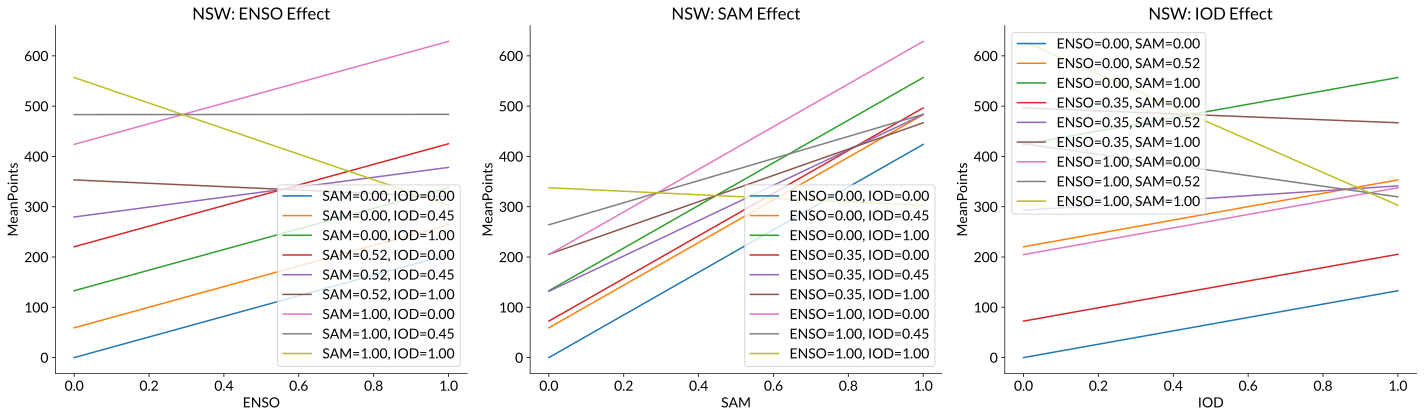

Partial Derivatives for QLD:
d(MeanPoints)/d(ENSO) = 94.30
d(MeanPoints)/d(SAM) = 17.58
d(MeanPoints)/d(IOD) = 12.80


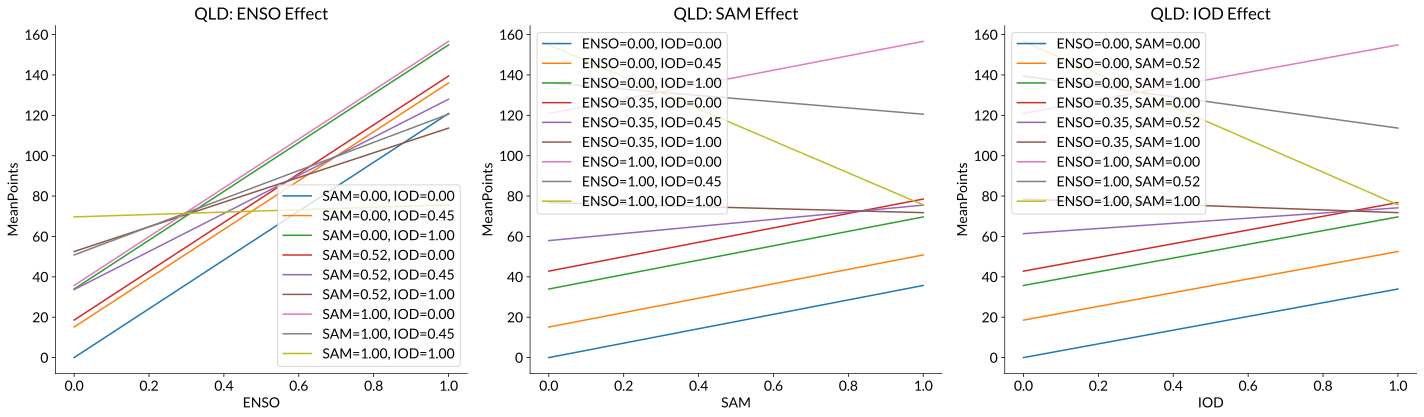

Partial Derivatives for VIC:
d(MeanPoints)/d(ENSO) = 40.12
d(MeanPoints)/d(SAM) = 315.21
d(MeanPoints)/d(IOD) = 51.32


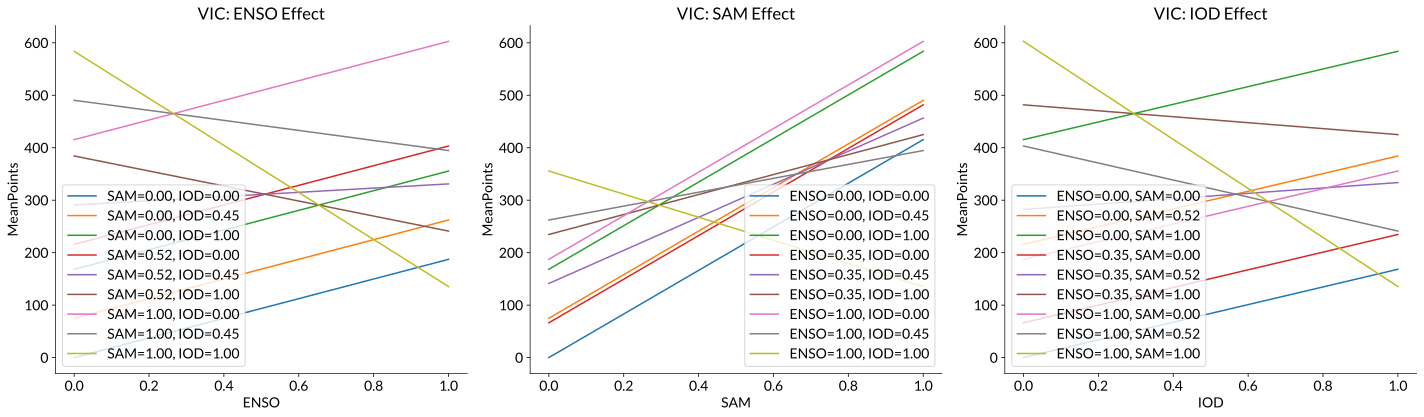

Partial Derivatives for WA:
d(MeanPoints)/d(ENSO) = -55.57
d(MeanPoints)/d(SAM) = 208.06
d(MeanPoints)/d(IOD) = 45.64


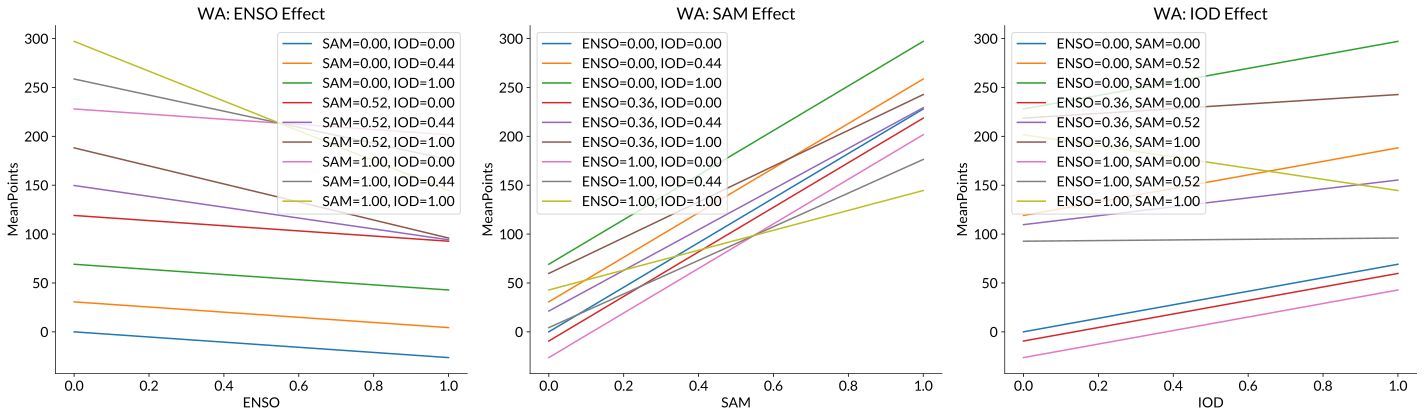

In [239]:

def analyze_interaction(state_name, model, X):
    # Extract coefficients
    b_enso = model.params['ENSO']
    b_sam = model.params['SAM']
    b_iod = model.params['IOD']
    b_interaction = model.params['ENSO_SAM_IOD']

    # Calculate partial derivatives
    d_enso = b_enso + b_interaction * X['SAM'].mean() * X['IOD'].mean()
    d_sam = b_sam + b_interaction * X['ENSO'].mean() * X['IOD'].mean()
    d_iod = b_iod + b_interaction * X['ENSO'].mean() * X['SAM'].mean()

    print(f"Partial Derivatives for {state_name}:")
    print(f"d(MeanPoints)/d(ENSO) = {d_enso:.2f}")
    print(f"d(MeanPoints)/d(SAM) = {d_sam:.2f}")
    print(f"d(MeanPoints)/d(IOD) = {d_iod:.2f}")

    # Slopes Analysis
    enso_range = np.linspace(X['ENSO'].min(), X['ENSO'].max(), 100)
    sam_range = np.linspace(X['SAM'].min(), X['SAM'].max(), 100)
    iod_range = np.linspace(X['IOD'].min(), X['IOD'].max(), 100)

    # Plot ENSO effect at different SAM and IOD levels
    plt.figure(figsize=(20, 6))
    plt.subplot(131)
    for sam in [X['SAM'].min(), X['SAM'].mean(), X['SAM'].max()]:
        for iod in [X['IOD'].min(), X['IOD'].mean(), X['IOD'].max()]:
            y = b_enso * enso_range + b_sam * sam + b_iod * iod + b_interaction * enso_range * sam * iod
            plt.plot(enso_range, y, label=f'SAM={sam:.2f}, IOD={iod:.2f}')
    plt.xlabel('ENSO')
    plt.ylabel('MeanPoints')
    plt.title(f'{state_name}: ENSO Effect')
    plt.legend()

    # Plot SAM effect at different ENSO and IOD levels
    plt.subplot(132)
    for enso in [X['ENSO'].min(), X['ENSO'].mean(), X['ENSO'].max()]:
        for iod in [X['IOD'].min(), X['IOD'].mean(), X['IOD'].max()]:
            y = b_enso * enso + b_sam * sam_range + b_iod * iod + b_interaction * enso * sam_range * iod
            plt.plot(sam_range, y, label=f'ENSO={enso:.2f}, IOD={iod:.2f}')
    plt.xlabel('SAM')
    plt.ylabel('MeanPoints')
    plt.title(f'{state_name}: SAM Effect')
    plt.legend()

    # Plot IOD effect at different ENSO and SAM levels
    plt.subplot(133)
    for enso in [X['ENSO'].min(), X['ENSO'].mean(), X['ENSO'].max()]:
        for sam in [X['SAM'].min(), X['SAM'].mean(), X['SAM'].max()]:
            y = b_enso * enso + b_sam * sam + b_iod * iod_range + b_interaction * enso * sam * iod_range
            plt.plot(iod_range, y, label=f'ENSO={enso:.2f}, SAM={sam:.2f}')
    plt.xlabel('IOD')
    plt.ylabel('MeanPoints')
    plt.title(f'{state_name}: IOD Effect')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Analyze NSW and QLD
for state_name in ['NSW', 'QLD', 'VIC', 'WA']:
    state = state_dfs[state_name]
    X = state[['ENSO', 'SAM', 'IOD']]
    y = state['MeanPoints']

    # Standardize the independent variables
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Create interaction terms
    X_scaled['ENSO_SAM_IOD'] = X_scaled['ENSO'] * X_scaled['SAM'] * X_scaled['IOD']

    # Add a constant to the model (intercept)
    X_scaled = sm.add_constant(X_scaled)

    # Fit the regression model
    model = sm.OLS(y, X_scaled).fit()

    analyze_interaction(state_name, model, X_scaled)

## Predictor

In [240]:
def export_model_params(df, states):
    model_params = {}
    
    for state in states:
        # Create mask for non-null values in both target and features
        mask = df[state].notna()
        for col in ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']:
            mask = mask & df[col].notna() & np.isfinite(df[col])
        
        # Filter X and y using the mask
        X = df.loc[mask, ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
        y = df.loc[mask, state]
        
        print(f"\nFor {state}:")
        print(f"Original rows: {len(df)}")
        print(f"Rows after removing NaN: {len(X)}")
        
        means = {
            'ENSO': float(X['ENSO'].mean()),
            'SAM': float(X['SAM'].mean()),
            'IOD': float(X['IOD'].mean())
        }
        
        # Get scaling parameters
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)  # Keep the index
        
        # Create interaction terms DataFrame with the SAME index as X_scaled
        X_interactions = pd.DataFrame(index=X_scaled.index)  # Use X_scaled's index
        X_interactions['const'] = 1.0
        X_interactions['ENSO'] = X_scaled['ENSO']
        X_interactions['SAM'] = X_scaled['SAM']
        X_interactions['IOD'] = X_scaled['IOD']
        X_interactions['Month_Sin'] = X_scaled['Month_Sin']
        X_interactions['Month_Cos'] = X_scaled['Month_Cos']
        
        # Add interaction terms
        X_interactions['ENSO_SAM'] = (X['ENSO'] - means['ENSO']) * (X['SAM'] - means['SAM'])
        X_interactions['ENSO_IOD'] = (X['ENSO'] - means['ENSO']) * (X['IOD'] - means['IOD'])
        X_interactions['SAM_IOD'] = (X['SAM'] - means['SAM']) * (X['IOD'] - means['IOD'])
        X_interactions['ENSO_SAM_IOD'] = (X['ENSO'] - means['ENSO']) * \
                                        (X['SAM'] - means['SAM']) * \
                                        (X['IOD'] - means['IOD'])
        
        # Verify no NaN values before fitting
        if X_interactions.isna().any().any():
            print("Warning: NaN values found in X_interactions")
            print(X_interactions.isna().sum())
            # Drop rows with NaN values if any exist
            X_interactions = X_interactions.dropna()
            y = y.loc[X_interactions.index]
        
        # Fit model
        model = sm.OLS(y, X_interactions).fit()
        
        # Store parameters
        model_params[state] = {
            'coefficients': {k: float(v) for k, v in model.params.to_dict().items()},
            'scaling': {
                'min': [float(x) for x in scaler.data_min_],
                'max': [float(x) for x in scaler.data_max_],
                'mean': means,
                'features': ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']
            }
        }
        
        # Print debug info for verification
        if state == 'NSW':
            print(f"\nDebug info for {state}:")
            print("Means:", means)
            print("Scaling min:", scaler.data_min_)
            print("Scaling max:", scaler.data_max_)
            print("First few coefficients:", dict(list(model.params.items())[:3]))
    
    # Convert to JSON and save to a file
    with open('model_params.js', 'w') as f:
        f.write('const modelParams = ')
        # Write the JSON data
        json.dump(model_params, f, indent=2)
        # Add a semicolon at the end
        f.write(';')
    
    print("\nModel parameters exported to 'model_params.js'")
    
    return model_params

In [241]:
model_params = export_model_params(df, states)


For NSW:
Original rows: 204
Rows after removing NaN: 204

Debug info for NSW:
Means: {'ENSO': -0.11274509803921569, 'SAM': 0.6347712418300655, 'IOD': 0.09553431372549018}
Scaling min: [-1.6        -2.72333333 -0.54833333 -1.         -1.        ]
Scaling max: [2.6        3.73666667 0.89733333 1.         1.        ]
First few coefficients: {'const': -49.142423153579436, 'ENSO': 92.96269620046995, 'SAM': 71.72716440162162}

For VIC:
Original rows: 204
Rows after removing NaN: 204

For QLD:
Original rows: 204
Rows after removing NaN: 204

For WA:
Original rows: 204
Rows after removing NaN: 198

For SA:
Original rows: 204
Rows after removing NaN: 194

Model parameters exported to 'model_params.js'


In [242]:
def predict_points(enso, sam, iod, month, model_params):
    """
    Predicts MeanPoints for each state based on ENSO, SAM, IOD, and month.

    Parameters:
    - enso (float): ENSO value
    - sam (float): SAM value
    - iod (float): IOD value
    - month (int): Month as an integer (1=January, ..., 12=December)
    - model_params (dict): Precomputed model parameters for each state

    Returns:
    - predictions (dict): Predicted MeanPoints for each state
    """
    predictions = {}
    
    # Convert month to cyclic features
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    
    for state in states:
        params = model_params[state]
        coefficients = params['coefficients']
        scaling = params['scaling']
        
        # Extract scaling parameters
        scaling_min = scaling['min']
        scaling_max = scaling['max']
        means = scaling['mean']
        feature_names = scaling['features']
        
        # Create a dictionary to map feature names to their indices
        feature_indices = {name: idx for idx, name in enumerate(feature_names)}
        
        # Prepare input features in the order: ENSO, SAM, IOD, Month_Sin, Month_Cos
        input_features = np.array([enso, sam, iod, month_sin, month_cos]).reshape(1, -1)
        
        # Apply scaling using MinMaxScaler parameters
        # Formula: X_scaled = (X - min) / (max - min)
        # To avoid division by zero, ensure (max - min) != 0
        scaled_features = []
        for i in range(len(feature_names)):
            min_val = scaling_min[i]
            max_val = scaling_max[i]
            if max_val - min_val != 0:
                scaled = (input_features[0, i] - min_val) / (max_val - min_val)
            else:
                scaled = 0.0  # If no variation, set scaled value to 0
            scaled_features.append(scaled)
        scaled_features = np.array(scaled_features)
        
        # Extract means for interaction terms from training data
        enso_mean = means['ENSO']
        sam_mean = means['SAM']
        iod_mean = means['IOD']
        
        # Calculate interaction terms based on original means
        enso_sam = (enso - enso_mean) * (sam - sam_mean)
        enso_iod = (enso - enso_mean) * (iod - iod_mean)
        sam_iod = (sam - sam_mean) * (iod - iod_mean)
        enso_sam_iod = (enso - enso_mean) * (sam - sam_mean) * (iod - iod_mean)
        
        # Construct the input vector including interactions
        input_vector = {
            'const': 1.0,
            'ENSO': scaled_features[0],
            'SAM': scaled_features[1],
            'IOD': scaled_features[2],
            'Month_Sin': scaled_features[3],
            'Month_Cos': scaled_features[4],
            'ENSO_SAM': enso_sam,
            'ENSO_IOD': enso_iod,
            'SAM_IOD': sam_iod,
            'ENSO_SAM_IOD': enso_sam_iod
        }
        
        # Ensure all coefficients are present; if not, set to 0
        for key in coefficients:
            if key not in input_vector:
                input_vector[key] = 0.0
        
        # Create a DataFrame for the input vector
        input_df = pd.DataFrame([input_vector])
        
        # Calculate prediction using dot product of coefficients and input features
        # Ensure the order of features matches
        prediction = 0.0
        for key, value in input_vector.items():
            if key in coefficients:
                prediction += coefficients[key] * value
        
        predictions[state] = prediction
    
    return predictions

In [243]:
# Define your current conditions
current_conditions = {
    'ENSO': 3,
    'SAM': -3,
    'IOD': 1,
    'Month': 9  # January
}

# Make predictions
predictions = predict_points(
    enso=current_conditions['ENSO'],
    sam=current_conditions['SAM'],
    iod=current_conditions['IOD'],
    month=current_conditions['Month'],
    model_params=model_params
)

# Print predictions
for state, points in predictions.items():
    print(f"{state}: {points:.2f} points")

NSW: 660.87 points
VIC: 196.63 points
QLD: 940.54 points
WA: 218.97 points
SA: 312.20 points


## Finding the best conditions

In [245]:
from scipy.optimize import minimize

def predict_points_for_optimization(conditions, state_name, month, model_params):
    """Helper function that returns negative points (for minimization)"""
    enso, sam, iod = conditions
    predictions = predict_points(enso, sam, iod, month, model_params)
    return -predictions[state_name]  # Negative because we want to maximize

def find_optimal_conditions(state_name, month, model_params):
    # Initial guess
    x0 = [0, 0, 0]  # Starting with neutral conditions
    
    # Bounds for each parameter (based on historical ranges)
    bounds = [
        (-3.0, 3.0),  # ENSO bounds
        (-3.0, 4.0),  # SAM bounds
        (-1.0, 1.0)   # IOD bounds
    ]
    
    # Find the optimal conditions
    result = minimize(
        predict_points_for_optimization,
        x0,
        args=(state_name, month, model_params),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    optimal_enso, optimal_sam, optimal_iod = result.x
    optimal_points = -result.fun  # Convert back to positive
    
    return {
        'ENSO': optimal_enso,
        'SAM': optimal_sam,
        'IOD': optimal_iod,
        'Predicted Points': optimal_points
    }

# Find optimal conditions for each state
for month in [9, 10, 11, 12, 1]:  # Check each season
    print(f"\nOptimal conditions for month {month}:")
    print("-" * 50)
    for state in states:
        optimal = find_optimal_conditions(state, month, model_params)
        print(f"\n{state}:")
        print(f"ENSO: {optimal['ENSO']:.2f}")
        print(f"SAM: {optimal['SAM']:.2f}")
        print(f"IOD: {optimal['IOD']:.2f}")
        print(f"Predicted Points: {optimal['Predicted Points']:.2f}")


Optimal conditions for month 9:
--------------------------------------------------

NSW:
ENSO: 3.00
SAM: 4.00
IOD: -1.00
Predicted Points: 1196.65

VIC:
ENSO: 3.00
SAM: 4.00
IOD: -1.00
Predicted Points: 720.66

QLD:
ENSO: 3.00
SAM: -3.00
IOD: 1.00
Predicted Points: 940.54

WA:
ENSO: -3.00
SAM: 4.00
IOD: 1.00
Predicted Points: 304.36

SA:
ENSO: 3.00
SAM: 4.00
IOD: -1.00
Predicted Points: 813.17

Optimal conditions for month 10:
--------------------------------------------------

NSW:
ENSO: 3.00
SAM: 4.00
IOD: -1.00
Predicted Points: 1362.06

VIC:
ENSO: 3.00
SAM: 4.00
IOD: -1.00
Predicted Points: 849.36

QLD:
ENSO: 3.00
SAM: -3.00
IOD: 1.00
Predicted Points: 995.30

WA:
ENSO: -3.00
SAM: 4.00
IOD: 1.00
Predicted Points: 396.41

SA:
ENSO: 3.00
SAM: 4.00
IOD: -1.00
Predicted Points: 902.04

Optimal conditions for month 11:
--------------------------------------------------

NSW:
ENSO: 3.00
SAM: 4.00
IOD: -1.00
Predicted Points: 1506.63

VIC:
ENSO: 3.00
SAM: 4.00
IOD: -1.00
Predicted Points

## Some other code I needed for the JavaScript integration

In [246]:
def export_model_params(df, states):
    model_params = {}
    
    for state in states:
        # Create mask for non-null values in both target and features
        mask = df[state].notna()  # Start with state column
        for col in ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']:
            mask = mask & df[col].notna() & np.isfinite(df[col])
        
        # Filter X and y using the mask
        X = df.loc[mask, ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
        y = df.loc[mask, state]
        
        print(f"\nFor {state}:")
        print(f"Original rows: {len(df)}")
        print(f"Rows after removing NaN: {len(X)}")
        
        means = {
            'ENSO': float(X['ENSO'].mean()),
            'SAM': float(X['SAM'].mean()),
            'IOD': float(X['IOD'].mean())
        }
        
        # Get scaling parameters
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)  # Keep the index
        
        # Create interaction terms DataFrame with the SAME index as X_scaled
        X_interactions = pd.DataFrame(index=X_scaled.index)  # Use X_scaled's index
        X_interactions['const'] = 1.0
        X_interactions['ENSO'] = X_scaled['ENSO']
        X_interactions['SAM'] = X_scaled['SAM']
        X_interactions['IOD'] = X_scaled['IOD']
        X_interactions['Month_Sin'] = X_scaled['Month_Sin']
        X_interactions['Month_Cos'] = X_scaled['Month_Cos']
        
        # Add interaction terms
        X_interactions['ENSO_SAM'] = (X['ENSO'] - means['ENSO']) * (X['SAM'] - means['SAM'])
        X_interactions['ENSO_IOD'] = (X['ENSO'] - means['ENSO']) * (X['IOD'] - means['IOD'])
        X_interactions['SAM_IOD'] = (X['SAM'] - means['SAM']) * (X['IOD'] - means['IOD'])
        X_interactions['ENSO_SAM_IOD'] = (X['ENSO'] - means['ENSO']) * \
                                        (X['SAM'] - means['SAM']) * \
                                        (X['IOD'] - means['IOD'])
        
        # Verify no NaN values before fitting
        if X_interactions.isna().any().any():
            print("Warning: NaN values found in X_interactions")
            print(X_interactions.isna().sum())
            # Drop rows with NaN values if any exist
            X_interactions = X_interactions.dropna()
            y = y.loc[X_interactions.index]
        
        # Fit model
        model = sm.OLS(y, X_interactions).fit()
        
        # Store parameters
        model_params[state] = {
            'coefficients': {k: float(v) for k, v in model.params.to_dict().items()},
            'scaling': {
                'min': scaler.data_min_.tolist(),
                'max': scaler.data_max_.tolist(),
                'mean': means,
                'features': ['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']
            }
        }
        
        # Print debug info for verification
        if state == 'NSW':
            print(f"\nDebug info for {state}:")
            print("Means:", means)
            print("Scaling min:", scaler.data_min_)
            print("Scaling max:", scaler.data_max_)
            print("First few coefficients:", dict(list(model.params.items())[:3]))
    
    # Convert to JavaScript
    js_code = f"const modelParams = {json.dumps(model_params, indent=2)};"
    
    # Save to file
    with open('model_params.js', 'w') as f:
        f.write(js_code)
    
    return model_params